In [43]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

data_dir = "./dataset"


In [44]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(100, 100),
  batch_size=32)

Found 5876 files belonging to 2 classes.
Using 4701 files for training.


In [45]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(100, 100),
  batch_size=32)

Found 5876 files belonging to 2 classes.
Using 1175 files for validation.


In [46]:
class_names = train_ds.class_names
print(class_names)

['abstract_images', 'non_abstract_images']


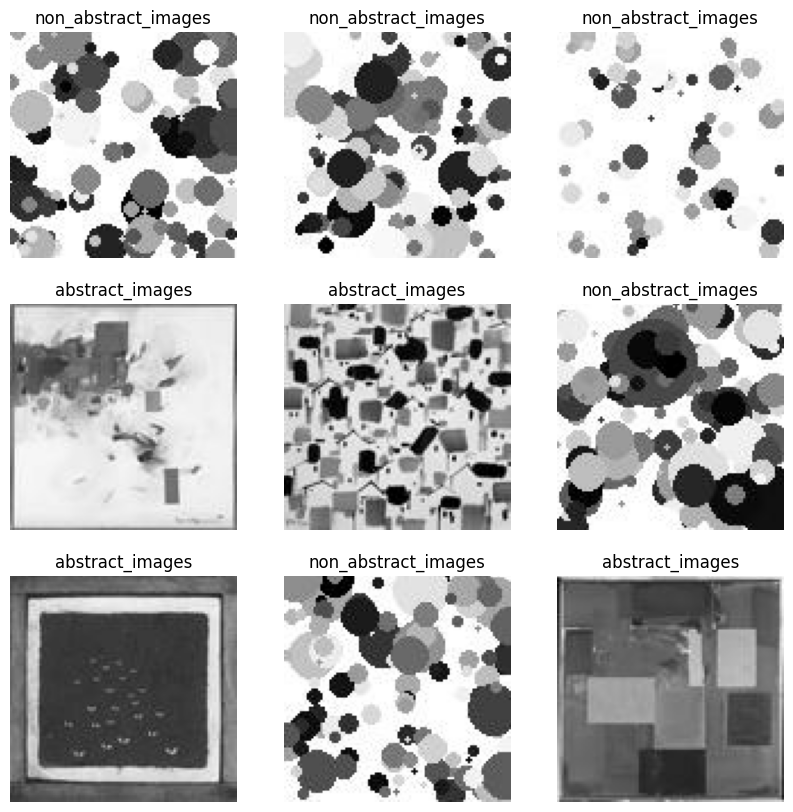

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [48]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [49]:
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [50]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(100, 100, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes)
])

In [51]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [52]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 100, 100, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 100, 100, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 50, 50, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 50, 50, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 25, 25, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 25, 25, 64)       

In [53]:
epochs= 1000
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks = [es]
)

Epoch 1/1000
147/147 [==============================] - 16s 102ms/step - loss: 0.1978 - accuracy: 0.9045 - val_loss: 0.0152 - val_accuracy: 0.9983
Epoch 2/1000
147/147 [==============================] - 15s 103ms/step - loss: 0.0165 - accuracy: 0.9949 - val_loss: 0.0406 - val_accuracy: 0.9881
Epoch 2: early stopping


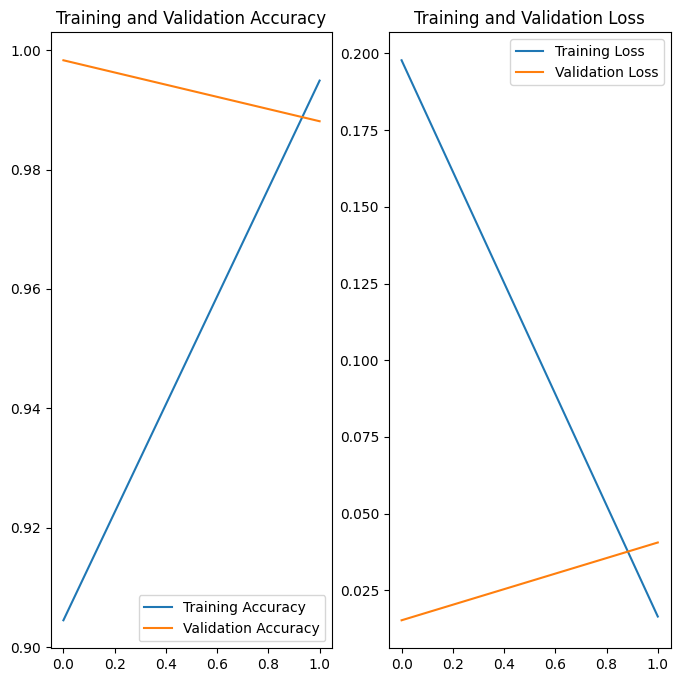

In [54]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [55]:
#save the model
model.save("my_model")

INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets


In [56]:
#test prediction with the model
img = tf.keras.utils.load_img(
    "./dataset/abstract_images/abstract_image0.jpg"
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = model.predict(img_array)
print(predictions)

img = tf.keras.utils.load_img(
    "./dataset/non_abstract_images/non_abstract_image0.jpg"
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = model.predict(img_array)
print(predictions)

1/1 [==============================] - 0s 61ms/step
[[ 3.8013422 -3.017224 ]]
1/1 [==============================] - 0s 17ms/step
[[-6.68456   8.520328]]


In [58]:
for i in range(0,10):
#test prediction with the model
    img = tf.keras.utils.load_img(
        "./dataset/abstract_images/abstract_image" + str(i) + ".jpg"
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model.predict(img_array)
    print(predictions[0][0] - predictions[0][1])

1/1 [==============================] - 0s 18ms/step
[[ 3.8013422 -3.017224 ]]
1/1 [==============================] - 0s 19ms/step
[[ 3.8784242 -3.109378 ]]
1/1 [==============================] - 0s 19ms/step
[[ 3.9909966 -3.186493 ]]
1/1 [==============================] - 0s 20ms/step
[[0.2819866  0.48833084]]
1/1 [==============================] - 0s 22ms/step
[[ 3.1066334 -2.3745987]]
1/1 [==============================] - 0s 20ms/step
[[ 2.5315857 -1.8395469]]
1/1 [==============================] - 0s 20ms/step
[[ 4.1062474 -3.3197021]]
1/1 [==============================] - 0s 19ms/step
[[ 3.0175107 -2.1689327]]
1/1 [==============================] - 0s 19ms/step
[[ 3.517652 -2.803349]]
1/1 [==============================] - 0s 18ms/step
[[ 3.604262  -2.8999734]]
